In [1]:
# 只使用RDD导入sparkContext即可
from pyspark import SparkContext

# 创建本地SparkContext对象，作为程序入口
sc = SparkContext("local[*]", "lesson3")

## RDD 高频算子
今天介绍RDD中其他使用频率较高的的算子，包含图中高亮部分的算子

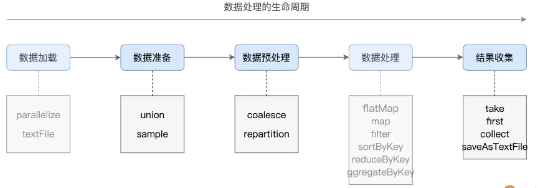

1. 在数据准备阶段，union 与 sample 用于对不同来源的数据进行合并与拆分
2. 接下来数据预处理环节。较为均衡的数据分布，对后面数据处理阶段提升 CPU 利用率更有帮助，可以整体提升执行效率，这时就要 coalesce 与 repartition 登场，它们的作用就是重新调整 RDD 数据分布
3. 在数据处理完成之后，要对计算结果进行收集。Spark 提供了两类结果收集算子，一类是像 take、first、collect 这样，把结果直接收集到 Driver 端；另一类则是直接将计算结果持久化到（分布式）文件系统，比如 saveAsTextFile

### 数据准备

#### 1. union
该算子用于把两个类型一致、但来源不同的 RDD 进行合并，从而构成一个统一的、更大的分布式数据集。
例如，在某个数据分析场景中，一份数据源来自远端数据库，而另一份数据源来自本地文件系统，要将两份数据进行合并，我们就需要用到 union 这个操作。
union 操作能够成立的前提，就是参与合并的两个 RDD 的类型必须完全一致
```python
rdd1 = _
rdd2 = _
rdd1.union(rdd2)
```
#### 2. sample
RDD 的 sample 算子用于对 RDD 做随机采样，从而把一个较大的数据集变为一份“小数据”。相较其他算子，sample 的参数比较多，分别是 withReplacement、fraction 和 seed。因此，要在 RDD 之上完成数据采样，你需要使用如下的方式来调用 sample 算子：sample(withReplacement, fraction, seed)

withReplacement 的类型是 Boolean，它的含义是“采样是否有放回”，如果这个参数的值是 true，那么采样结果中可能会包含重复的数据记录，相反，如果该值为 false，那么采样结果不存在重复记录。fraction 参数最好理解，它的类型是 Double，值域为 0 到 1，其含义是采样比例，也就是结果集与原数据集的尺寸比例。seed 参数是可选的，它的类型是 Long，也就是长整型，用于控制每次采样的结果是否一致。不带seed，则默认使用随机值作为种子，每次采用结果不同

In [4]:
arr = sc.parallelize(x for x in range(1, 100))
arr.sample?

Signature:
arr.sample(
    withReplacement: bool,
    fraction: float,
    seed: Optional[int] = None,
) -> 'RDD[T]'
Docstring:
Return a sampled subset of this RDD.

.. versionadded:: 0.7.0

Parameters
----------
withReplacement : bool
    can elements be sampled multiple times (replaced when sampled out)
fraction : float
    expected size of the sample as a fraction of this RDD's size
    without replacement: probability that each element is chosen; fraction must be [0, 1]
    with replacement: expected number of times each element is chosen; fraction must be >= 0
seed : int, optional
    seed for the random number generator

Returns
-------
:class:`RDD`
    a new :class:`RDD` containing a sampled subset of elements

See Also
--------
:meth:`RDD.takeSample`
:meth:`RDD.sampleByKey`
:meth:`pyspark.sql.DataFrame.sample`

Notes
-----
This is not guaranteed to provide exactly the fraction specified of the total
count of the given :class:`DataFrame`.

Examples
--------
>>> rdd = sc.parallel

有了 union 和 sample，使用者就可以随意地调整分布式数据集的尺寸

### 数据预处理

假设 Spark 作业的 Executors 个数为 N，每个 Executors 配置的 CPU 个数为 C，那么RDD默认设置的并行度partitions一般为N * C，开发者可以根据需要重新设置数据的分区数

#### 1. repartition
给定 RDD，我们就可以通过调用 repartition(n) 来随意调整 RDD 并行度。其中参数 n 的类型是 Int，也就是整型，因此，我们可以把任意整数传递给 repartition

In [7]:
arr.getNumPartitions()

arr2 = arr.repartition(4)
arr2.getNumPartitions()

8

repartition 非常灵活，你可以用它随意地调整 RDD 并行度，但是你也需要注意，这个算子有个致命的弊端，那就是它会引入 Shuffle,假设需求是降低并行度又不想引入shuffle，这个时候可以使用coalesce算子

#### 2. coalesce
在用法上，coalesce 与 repartition 可以互换，二者的效果是完全一致的,但是实现原理完全不同

具体来说，给定任意一条数据记录，repartition 的计算过程都是先哈希、再取模，得到的结果便是该条数据的目标分区索引。对于绝大多数的数据记录，目标分区往往坐落在另一个 Executor、甚至是另一个节点之上，因此 Shuffle 自然也就不可避免。coalesce 则不然，在降低并行度的计算中，它采取的思路是把同一个 Executor 内的不同数据分区进行合并，如此一来，数据并不需要跨 Executors、跨节点进行分发，因而自然不会引入 Shuffle

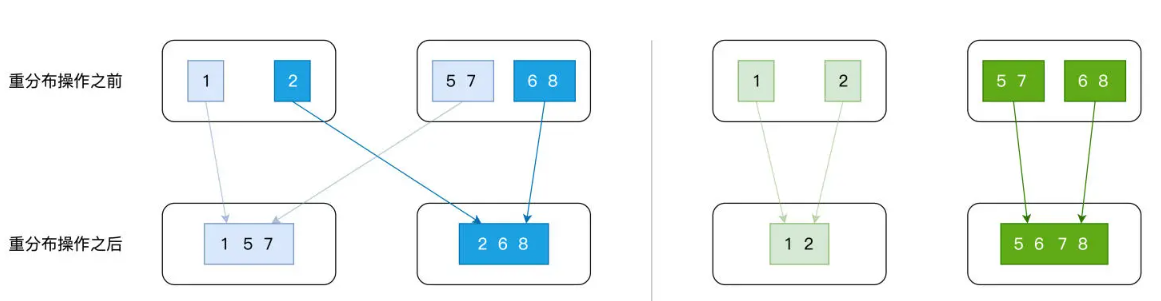

### 结果收集
完成处理之后，我们自然要收集计算结果。在结果收集方面，Spark 的算子按照收集路径区分主要分为两类：第一类是把计算结果从各个 Executors 收集到 Driver 端，第二个类是把计算结果通过 Executors 直接持久化到文件系统。在大数据处理领域，文件系统往往指的是像 HDFS 或是 S3 这样的分布式文件系统

#### 1. first、take 和 collect
其中，first 用于收集 RDD 数据集中的任意一条数据记录，而 take(n: Int) 则用于收集多条记录，记录的数量由 Int 类型的参数 n 来指定 
这两个算子的作用主要在于数据探索，在编写数据转换逻辑时可以用 first 或是 take 来获取几条计算结果，从而确保转换逻辑与预期一致

collect 拿到的不是部分结果，而是全量数据，也就是把 RDD 的计算结果全量地收集到 Driver 端，因此collect 算子有两处性能隐患，
一个是拉取数据过程中引入的网络开销，另一个 Driver 的 OOM（内存溢出，Out of Memory）

出于这些原因，在使用 collect 算子之前务必要慎重。如果业务逻辑是需要收集全量结果，建议使用下面的算子持久化到磁盘上

#### 2. saveAsTextFile

对于全量的结果集，可以使用第二类算子把它们直接持久化到磁盘。在这类算子中，最具代表性的非 saveAsTextFile 莫属，它的用法非常简单，给定 RDD，调用 saveAsTextFile(path: String) 即可。其中 path 代表的是目标文件系统目录，可以是本地文件系统，也可以是 HDFS、Amazon S3 等分布式文件系统

saveAsTextFile直接通过 Executors 将 RDD 数据分区物化到文件系统，这个过程并不涉及与 Driver 端的任何交互

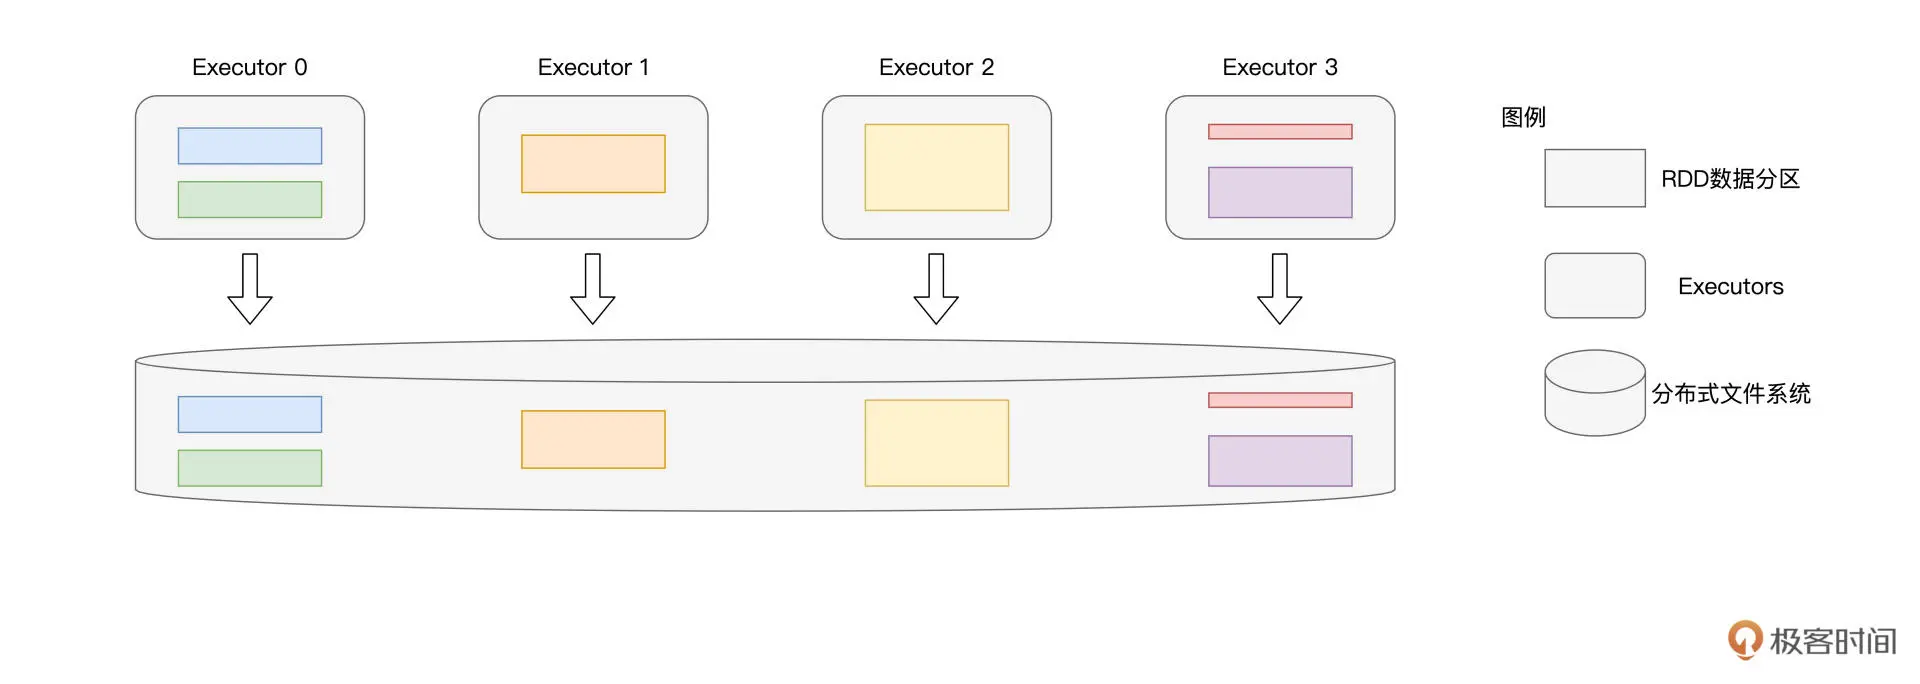

## 共享变量
对于 Executors 来说，分区中的数据都是局部数据。换句话说，在同一时刻，隶属于某个 Executor 的数据分区，对于其他 Executors 来说是不可见的。而在做应用开发的时候，总会有一些计算逻辑需要访问“全局变量”，比如说全局计数器，而这些全局变量在任意时刻对所有的 Executors 都是可见的、共享的，针对这一场景，Spark 提供了两类共享变量，分别是广播变量（Broadcast variables）和累加器（Accumulators）

In [10]:
word_rdd = sc.textFile("./data/wikiOfSpark.txt").flatMap(lambda line: line.split(" "))

### 广播变量
给定普通变量 x，通过调用 SparkContext 下的 broadcast API 即可在driver端完成广播变量的创建

普通的在driver端创建的变量会分发到每个task的内存空间，而使用广播变量只需要分发到每个Executor中的内存空间即可，当遇到需要多个 Task 共享同一个大型变量（如列表、数组、映射等数据结构）的时候，就可以考虑使用广播变量来优化你的 Spark 作业

示例分析：只统计文本中特定单词出现的次数比如 [spark, Apache] 这两个单词在文本中出现的次数

In [13]:
word_list = ["Spark", "Apache"]
bc = sc.broadcast(word_list)

# 使用bc.value对RDD进行过滤
clean_word_rdd= word_rdd.filter(lambda word: word in bc.value)
kv_rdd = clean_word_rdd.map(lambda x: (x, 1))
word_count = kv_rdd.reduceByKey(lambda x, y: x + y)

word_count.collect()

[('Apache', 34), ('Spark', 63)]

### 累加器

全局累加器，累加器也是在 Driver 端定义的，更新是通过调用 add 函数完成的，可以满足分布式运算的全局计数信息

需求分析：统计wordcount案例中，统计被过滤的空白字符的数量


In [16]:
ac = sc.accumulator(0)

def f1(word):
    if word == "":
        ac.add(1)
        return False
    return True


clean_word_rdd = word_rdd.filter(f1)

print(clean_word_rdd.count())
ac.value


2579


79

## spark 存储系统

Spark 存储系统负责维护所有暂存在内存与磁盘中的数据，这些数据包括 Shuffle 中间文件、RDD Cache 以及广播变量

Shuffle 中间文件，指的正是Shuffle的两个阶段为了完成数据交换所仰仗的 data 与 index 文件。RDD Cache 指的是分布式数据集在内存或是磁盘中的物化，它往往有利于提升计算效率。广播变量上一讲我们刚刚介绍过，它的优势在于以 Executors 为粒度分发共享变量，从而大幅削减数据分发引入的网络与存储开销

spark 使用BlockManagerMaster与BlockManager对象进行存储管理 

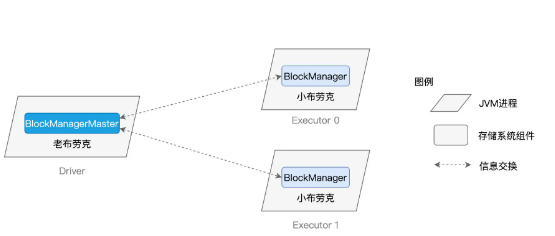

BlockManager通过driver的BlockManagerMaster 与其他BlockManager 之间交换 Executors 上数据的状态信息

BlockManager 在 Executors 中管理这 3 类数据的存储、读写与收发。就存储介质来说，这 3 类数据所消耗的硬件资源各不相同。具体来说，Shuffle 中间文件消耗的是节点磁盘，而广播变量主要占用节点的内存空间，RDD Cache 则是既可以消耗内存，也可以消耗磁盘

在 Executors 中，BlockManager 通过 MemoryStore 来完成内存的数据存取。MemoryStore 通过一种特殊的数据结构：LinkedHashMap 来完成 BlockId 到 MemoryEntry 的映射。其中，BlockId 记录着数据块的元数据，而 MemoryEntry 则用于封装数据实体。与此同时，BlockManager 通过 DiskStore 来实现磁盘数据的存取与访问。DiskStore 并不直接维护元数据列表，而是通过 DiskBlockManager 这个对象，来完成从数据库到磁盘文件的映射，进而完成数据访问

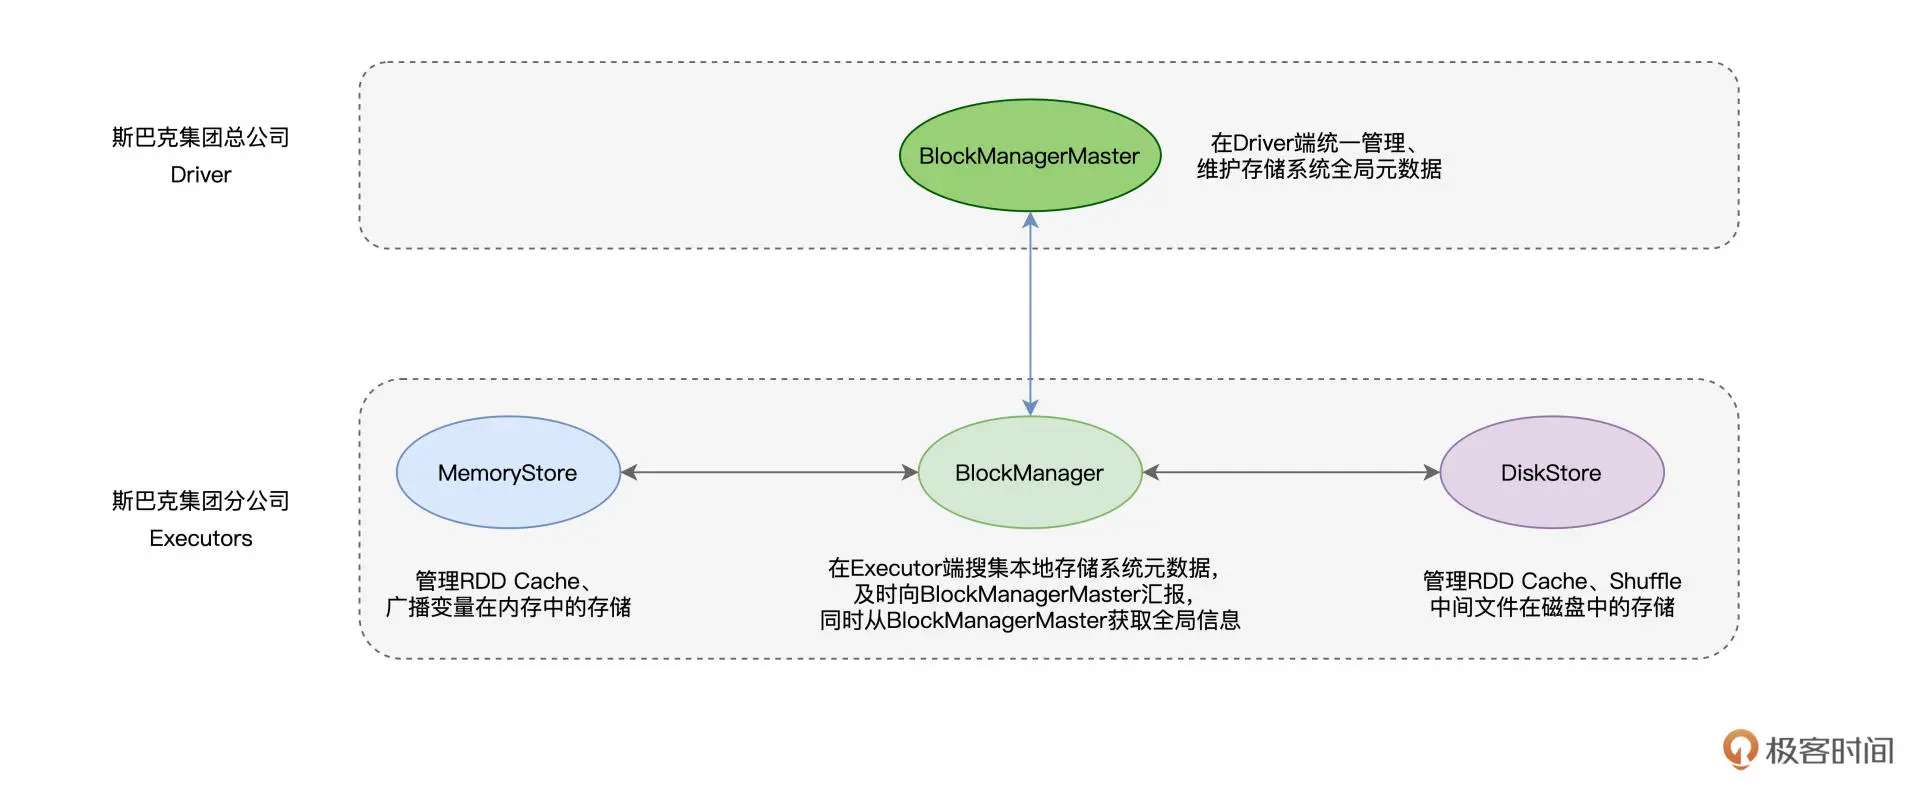